# Plotting time-series signatures from raw brdf imagery or smoothed ts outputs

In [1]:
import os
from pathlib import Path
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import shutil
import tempfile
import json
import random
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
from pyproj import CRS
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.geometry import Polygon
from rasterio.plot import show
import xarray as xr

%matplotlib inline

***Note: running more then 1 yr or so will take a long time on login node (where notebook is housed). Better to transfer TSprofile.py and TSprofile.sh to Bash folder and run desired time series through bash script, then use `LoadTSfromFile(TSfile)` to load time series here for plotting. 

In [40]:
smooth_dir = Path("/home/downspout-cel/chile_lc/raster/grids")
raw_dir = Path("/home/sandbox-cel/chile_lc/raster/grids")

out_dir = Path("/home/data/tmp")
gridFile = Path("/home/sandbox-cel/chile_lc/chl_grids.gpkg")
gridCell = 1157
PtFile = Path("/home/sandbox-cel/chile_lc/vector/sampleData/Arauco1A_Natural2014.txt")

In [33]:
def GetPtsInGrid (gridFile, gridCell, ptFile):
    '''
    loads point file (from .csv with 'XCoord' and 'YCoord' columns) and returns points that overlap a gridcell 
    as a geopandas GeoDataFrame. Use this if trying to match/append data to existing sample points 
    rather than making a new random sample each time (e.g. if matching Planet and Sentinel points)
    Note that crs of point file is known ahead of time and hardcoded here to match specific grid file.
    '''
    ptsdf = pd.read_csv(ptFile, index_col=0)
    ### pt file is in SA Albers Equal Area Conic (ESRI:102033)
    pts = gpd.GeoDataFrame(ptsdf,geometry=gpd.points_from_xy(ptsdf.XCoord,ptsdf.YCoord),crs='esri:102033')
    out_path = Path(gridFile).parent
    
    with tempfile.TemporaryDirectory(dir=out_path) as temp_dir:
        temp_file = Path(temp_dir) / Path(gridFile).name
        shutil.copy(gridFile, temp_file)
        df = gpd.read_file(temp_file)
        crs_grid = df.crs
    #print(crs_grid)  #ESRI:102033
    
    bb = df.query(f'UNQ == {gridCell}').geometry.total_bounds

    gridBbox = box(bb[0],bb[1],bb[2],bb[3])
    gridBounds = gpd.GeoDataFrame(gpd.GeoSeries(gridBbox), columns=['geometry'], crs=crs_grid)
    print(gridBounds)

    ptsInGrid = gpd.sjoin(pts, gridBounds, op='within')
    ptsInGrid = ptsInGrid.loc[:,['geometry']]
    
    print("Of the {} ppts, {} are in gridCell {}". format (pts.shape[0], ptsInGrid.shape[0],gridCell))
    
    #Write to geojson file
    if ptsInGrid.shape[0] > 0:
        ptClip = Path(os.path.join(out_path,'ptsGrid_'+str(gridCell)+'.json'))
        ptsInGrid.to_file(ptClip, driver="GeoJSON")
    
        return ptsInGrid
        print(ptsInGrid.head(n=5))

In [34]:
NatPts = GetPtsInGrid(gridFile, gridCell, PtFile)
NatPts.head(n=5)

                                            geometry
0  POLYGON ((-1121120.000 -620850.000, -1121120.0...


/home/klwalker/.nasaenv/lib64/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: ESRI:102033
Right CRS: ESRI:102033



Of the 1766 ppts, 232 are in gridCell 1157


,geometry
FID,
39197,POINT (-1124700.000 -614943.000)
40062,POINT (-1127130.000 -605756.000)
40063,POINT (-1126922.000 -606597.000)
40064,POINT (-1127200.000 -606433.000)
40065,POINT (-1127217.000 -606189.000)


In [36]:
def CalculateRawIndex(nir_val, b2_val, spec_index):
    if spec_index == 'evi2':
        index_val = 10000* 2.5 * ((nir_val - b2_val) / (nir_val + 1.0 + 2.4 * b2_val))
    elif spec_index == 'ndvi':
        index_val = 10000* (nir_val - b2_val) / ((nir_val + b2_val) + 1e-9)
    elif spec_index == 'savi':
        lfactor = .5 #(0-1, 0=very green, 1=very arid. .5 most common. Some use negative vals for arid env)
        index_val = 10000* (1 + lfactor) * ((nir_val - b2_val) / (nir_val + b2_val + lfactor))
    elif spec_index == 'msavi':
        index_val = 10000* 1/2 * (2 * nir_val + 1) - ((2 * nir_val + 1)**2 - 8*(nir_val - b2_val))**1/2
    elif spec_index == 'ndmi':
        index_val = 10000* (nir_val - b2_val) / ((nir_val + b2_val) + 1e-9)
    elif spec_index == 'ndwi':
        index_val = 10000* (b2_val - nir_val) / ((b2_val + nir_val) + 1e-9)
    elif spec_index == 'nir':
        index_val = 10000* nir_val
    elif spec_index in ['swir1','swir2','red','green']:
        index_val = 10000* b2_val
        
    return index_val

In [86]:
def GetIndexValsAtPts(TSstack, imageType, polys, spec_index, numPts, seed, loadSamp=False, ptgdb=None):
    '''
    Gets values for all sampled points {'numpts'} in all polygons {'polys'} for all images in {'TStack'}
    OR gets values for points in a previously generated dataframe {ptgdb} using loadSamp=True.
    
    If imageType == 'TS', indices are assumed to already be calculated and 
    {'TStack'} is a list of image paths, with basenames = YYYYDDD of image acquisition (DDD is Julien day, 1-365)
    
    If imageType == 'L1C' images are still in raw .nc form (6 bands) and indices are calculated here
    {'TStack'} is a list of image paths from which YYYYDDD info can be extracted
    
    output is a dataframe with a pt (named polygonID_pt#) 
    on each row and an image index value(named YYYYDDD) in each column
    
    '''
    if loadSamp == False:
        if polys:
            ptsgdb = getRanPtsInPolys (polys, numPts, seed)
        else:
            print('There are no polygons or points to process in this cell')
            return None
    elif loadSamp == True:
        ptsgdb = ptgdb
        
    xy = [ptsgdb['geometry'].x, ptsgdb['geometry'].y]
    coords = list(map(list, zip(*xy)))
                          
    if imageType == 'TS':
        for img in TSstack:
            img_name = os.path.basename(img)[:7]
            with rasterio.open(img, 'r') as src:
                ptsgdb[img_name] = [sample[0] for sample in src.sample(coords)]

    elif imageType == 'Sentinel' or imageType == 'Landsat' or imageType == 'All' :
        for img in TSstack:
            if os.path.basename(img).startswith('L1C'):
                YYYY = int(os.path.basename(img)[19:23])
                MM = int(os.path.basename(img)[23:25])
                DD = int(os.path.basename(img)[25:27])
            elif os.path.basename(img).startswith('LC') or img.startswith('LT') or img.startswith('LE'):
                YYYY = int(os.path.basename(img)[17:21])
                MM = int(os.path.basename(img)[21:23])
                DD = int(os.path.basename(img)[23:25])
            ymd = datetime.datetime(YYYY, MM, DD)
            doy = ymd.strftime('%j')
            img_name = str(YYYY)+doy
            xrimg = xr.open_dataset(img)
            xr_nir = xrimg['nir'].where(xrimg['nir'] < 10000)
            
            if spec_index in ['evi2','msavi','ndvi','savi','red']:
                xr_red = xrimg['red'].where(xrimg['red'] < 10000)
            elif spec_index in ['ndmi','swir1']:
                xr_swir1 = xrimg['swir1'].where(xrimg['swir1']< 10000)
            elif spec_index in ['ndwi','green']:
                xr_green = xrimg['green'].where(xrimg['green']< 10000)
            elif spec_index in ['swir2']:
                xr_swir2 = xrimg['swir2'].where(xrimg['swir2']< 10000)
            elif spec_index in ['nir']:
                pass
            else: print('{} is not specified or does not have current method'.format(spec_index))
                
            ptVals = []
            for index, row in ptsgdb.iterrows():
                thispt_nir = xr_nir.sel(x=ptsgdb['geometry'].x[index],y=ptsgdb['geometry'].y[index], 
                                        method='nearest', tolerance=30)
                nir_val = thispt_nir.values
                
                if spec_index in ['evi2','msavi','ndvi','savi','red']:
                    thispt_b2 = xr_red.sel(x=ptsgdb['geometry'].x[index],y=ptsgdb['geometry'].y[index],
                                method='nearest', tolerance=30)
                    b2_val = thispt_b2.values
                elif spec_index in ['ndmi','swir1']:
                    thispt_b2 = xr_swir1.sel(x=ptsgdb['geometry'].x[index],y=ptsgdb['geometry'].y[index],
                                method='nearest', tolerance=30)
                    b2_val = thispt_b2.values
                elif spec_index in ['ndwi','green']:
                    thispt_b2 = xr_green.sel(x=ptsgdb['geometry'].x[index],y=ptsgdb['geometry'].y[index],
                                method='nearest', tolerance=30)
                    b2_val = thispt_b2.values
                elif spec_index in ['swir2']:
                    thispt_b2 = xr_swir2.sel(x=ptsgdb['geometry'].x[index],y=ptsgdb['geometry'].y[index],
                                method='nearest', tolerance=30)
                    b2_val = thispt_b2.values
                elif spec_index in ['nir']:
                    b2_val = nir_val
                
                indexVal = CalculateRawIndex(nir_val, b2_val, spec_index)
                ptVals.append(indexVal)
                
            ptsgdb[img_name] = ptVals
                
    return ptsgdb

In [87]:
def GetTimeSeriesForPts_MultiCell(out_dir, spec_index, StartYr, EndYr, img_dir, imageType, gridFile, cellList, 
                            groundPolys, oldest=2018, newest=2018, npts=2, seed=88, loadSamp=False, ptFile=None):
    '''
    Returns datetime dataframe of values for sampled pts (n={'npts}) for each polygon in {'polys'}
    OR for previously generated points with {loadSamp}=True and {ptFile}=path to .csv file 
     (.csv file needs 'XCoord' and 'YCoord' fields (in this case, groundpolys, oldest, newest, npts and seed are not used))
    for all images of {imageType} acquired between {'StartYr'} and {'EndYr'} in {'TS_Directory'} 
    imageType can be 'Sentinel', 'Landsat', or 'All'
    Output format is a datetime object with date (YYYY-MM-DD) on each row and sample name (polygonID_pt#) in columns
    '''
    
    Allpts = pd.DataFrame()
    
    for cell in cellList:
        TStack = []
        print ('working on cell {}'.format(cell))
        if loadSamp == True:
            points = GetPtsInGrid (gridFile, cell, ptFile)
            polys = None
        else:
            polys = GetPolygonsInGrid (gridFile, cell, groundPolys, oldest, newest)
            points = None
        if isinstance(points, gpd.GeoDataFrame) or polys is not None:
            if imageType == 'TS':
                cellDir = os.path.join(img_dir,'{:06d}'.format(cell),'brdf_ts','ms',spec_index)
                for img in os.listdir(cellDir):
                    imgYr = int(img[:4])
                    if imgYr >= StartYr and imgYr <= EndYr:
                        TStack.append(os.path.join(img_dir,cellDir,img))

            else: 
                cellDir = os.path.join(img_dir,'{:06d}'.format(cell),'brdf')
                
                if imageType == 'Sentinel':
                    for img in os.listdir(cellDir):
                        if img.startswith('L1C') and 'angles' not in img:
                            imgYr = int(img[19:23])
                            if imgYr >= StartYr and imgYr <= EndYr:
                                TStack.append(os.path.join(img_dir,cellDir,img))
                if imageType == 'Landsat':
                    for img in os.listdir(cellDir):
                        if img.startswith('LC') or img.startswith('LT') or img.startswith('LE'):
                            if 'angles' not in img:
                                imgYr = int(img[17:21])
                                if imgYr >= StartYr and imgYr <= EndYr:
                                    TStack.append(os.path.join(img_dir,cellDir,img))
                if imageType == 'All':
                    for img in os.listdir(cellDir):
                        if img.startswith('L1C') and 'angles' not in img:
                            imgYr = int(img[19:23])
                            if imgYr >= StartYr and imgYr <= EndYr:
                                    TStack.append(os.path.join(img_dir,cellDir,img))
                        elif img.startswith('LC') or img.startswith('LT') or img.startswith('LE'):
                            if 'angles' not in img:
                                imgYr = int(img[17:21])
                                if imgYr >= StartYr and imgYr <= EndYr:
                                    TStack.append(os.path.join(img_dir,cellDir,img))

            TStack.sort()
            if loadSamp == True:
                polys=None
                pts = GetIndexValsAtPts(TStack, imageType, polys, spec_index, 2, seed=88, loadSamp=True, ptgdb=points)
            else:
                pts = GetIndexValsAtPts(TStack, imageType, polys, spec_index, 2, seed=88, loadSamp=False, ptgdb=None)
            
            pts.drop(columns=['geometry'], inplace=True)
            Allpts = pd.concat([Allpts, pts])
    
        else:
            print('skipping this cell')
            pass
    
    TS = Allpts.transpose()
    TS['date'] = [pd.to_datetime(e[:4]) + pd.to_timedelta(int(e[4:]) - 1, unit='D') for e in TS.index]
    TS.set_index('date', drop=True, inplace=True)
    TS.index = pd.to_datetime(TS.index)

    TS['ALL'] = TS.mean(axis=1)
    TS['stdv'] = TS.std(axis=1)
    
    #pd.DataFrame(TS).to_csv(os.path.join(out_dir,'TS_{}_{}-{}.csv'.format(spec_index, StartYr, EndYr)), sep=',', na_rep='NaN', index=True)
    
    return TS
    
    
def LoadTSfromFile(TSfile):
    TS = pd.read_csv(TSfile)
    TS.set_index('date', drop=True, inplace=True)
    TS.index = pd.to_datetime(TS.index)
    
    return TS

In [88]:
def Convert_FullTimeSeries_toDOY(TSdf, Yr, StartDay=0, EndDay=365):
    newDF = TSdf[TSdf.index.year == Yr]
    #change index to just month-day:
    newDF.index = newDF.index.dayofyear
    newDF = newDF[newDF.index >= StartDay]
    newDF = newDF[newDF.index <= EndDay]
    
    return newDF

In [97]:
raw = GetTimeSeriesForPts_MultiCell(out_dir, 'evi2', 2014, 2018, raw_dir, 'All', gridFile, [1157], 
                            groundPolys=None, oldest=2018, newest=2018, npts=2, seed=88, loadSamp=True, ptFile=PtFile)

working on cell 1157
                                            geometry
0  POLYGON ((-1121120.000 -620850.000, -1121120.0...


/home/klwalker/.nasaenv/lib64/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: ESRI:102033
Right CRS: ESRI:102033



Of the 1766 ppts, 232 are in gridCell 1157


In [98]:
smooth = GetTimeSeriesForPts_MultiCell(out_dir, 'evi2', 2014, 2018, smooth_dir,'TS', gridFile, [1157], 
                            groundPolys=None, oldest=2018, newest=2018, npts=2, seed=88, loadSamp=True, ptFile=PtFile)

working on cell 1157
                                            geometry
0  POLYGON ((-1121120.000 -620850.000, -1121120.0...


/home/klwalker/.nasaenv/lib64/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: ESRI:102033
Right CRS: ESRI:102033



Of the 1766 ppts, 232 are in gridCell 1157


In [99]:
raw = raw[raw['ALL'] != 0]
smooth = smooth[smooth['ALL'] != 0]

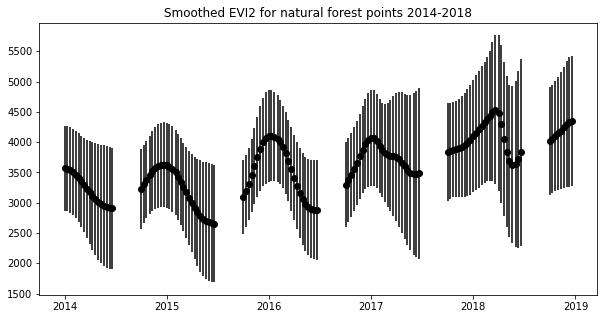

In [102]:
fig = plt.figure(figsize=(10, 5))
plt.errorbar(smooth.index, smooth['ALL'], yerr=smooth['stdv'], fmt='o', color='k')
#plt.errorbar(raw.index, raw['ALL'], yerr=raw['stdv'], fmt='o', color='g')
plt.title('Smoothed EVI2 for natural forest points 2014-2018')
plt.show()

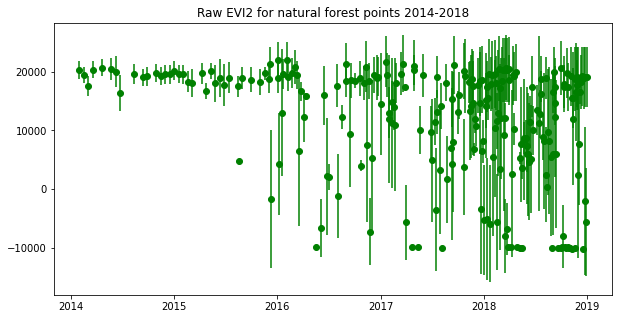

In [103]:
fig = plt.figure(figsize=(10, 5))
#plt.errorbar(smooth.index, smooth['ALL'], yerr=smooth['stdv'], fmt='o', color='k')
plt.errorbar(raw.index, raw['ALL'], yerr=raw['stdv'], fmt='o', color='g')
plt.title('Raw EVI2 for natural forest points 2014-2018')
plt.show()